In [1]:
import os, sys
sys.path.append("../common/")
from python_tools import *
import particle

python tools loaded.


In [2]:
@numba.jit
def calc_hadrons_numba(mass,px,py,pz,energy):
    thetaxz = np.arctan2(px,pz)
    thetayz = np.arctan2(py,pz)
    thetaz = np.arctan2(np.sqrt(np.square(px)+np.square(py)),pz)
    ke = energy-mass*1.e-3
    
    return thetaxz,thetayz,thetaz,ke


def calc_hadrons(pdg=None,px=None,py=None,pz=None,energy=None,s=None,numba=True):
    
    if s is not None:
        pdg = s[0]
        px = s[1]
        py = s[2]
        pz = s[3]
        energy = s[4]

    if numba:
        mass_mev = np.array([ particle.Particle.from_pdgid(p).mass for p in pdg ])
        return calc_hadrons_numba(mass_mev,px,py,pz,energy)
        
    thetaxz = np.arctan2(px,pz)
    thetayz = np.arctan2(py,pz)
    thetaz = np.arctan2(np.sqrt(np.square(px)+np.square(py)),pz)
    ke = np.array( [ (energy[i] - particle.Particle.from_pdgid(pdg[i]).mass*1e-3) for i in range(len(pdg)) ] )
    
    return thetaxz,thetayz,thetaz,ke

        
def acceptance_n(pdg=None,px=None,py=None,pz=None,energy=None,thetaz=None,ke=None,
                 thetaz_thresh_deg=40,ke_thresh_mev=500.,
                 s=None):
    
    if s is not None:
        pdg = s[0]
        px = s[1]
        py = s[2]
        pz = s[3]
        energy = s[4]
        thetaz = s[5]
        ke = s[6]
    
    #put in rad and GeV
    THETAZ_THRESH_RAD=np.radians(thetaz_thresh_deg)
    KE_THRESH_GEV=ke_thresh_mev*1e-3

    n_mask = (pdg==2112)
    accept = np.logical_and(pdg==2112,np.abs(thetaz)<THETAZ_THRESH_RAD)
    
    px_n1=np.nan
    py_n1=np.nan
    pz_n1=np.nan
    E_n1=np.nan
    ke_n1=np.nan
    thetaz_n1=np.nan
    if np.any(accept):
        n_sub_idx = np.argmax(ke[accept])
        n_max_idx = np.arange(ke.shape[0])[accept][n_sub_idx]
        px_n1=px[n_max_idx]
        py_n1=py[n_max_idx]
        pz_n1=pz[n_max_idx]
        E_n1=energy[n_max_idx]
        ke_n1=ke[n_max_idx]
        thetaz_n1=thetaz[n_max_idx]
            
    return accept,np.sum(np.logical_and(accept,ke>KE_THRESH_GEV)),px_n1,py_n1,pz_n1,E_n1,ke_n1,thetaz_n1
    

In [3]:
def acceptance_p(pdg=None,px=None,py=None,pz=None,energy=None,thetaz=None,ke=None,
                 thetaz_thresh_deg=40,ke_thresh_mev=100.,
                 s=None):
    
    if s is not None:
        pdg = s[0]
        px = s[1]
        py = s[2]
        pz = s[3]
        energy = s[4]
        thetaz = s[5]
        ke = s[6]
    
    #put in rad and GeV
    THETAZ_THRESH_RAD=np.radians(thetaz_thresh_deg)
    KE_THRESH_GEV=ke_thresh_mev*1e-3

    mask = (pdg==2212)
    accept = np.logical_and(mask,np.abs(thetaz)<THETAZ_THRESH_RAD)
    
    px_1=np.nan
    py_1=np.nan
    pz_1=np.nan
    E_1=np.nan
    ke_1=np.nan
    thetaz_1=np.nan
    if np.any(accept):
        sub_idx = np.argmax(ke[accept])
        max_idx = np.arange(ke.shape[0])[accept][sub_idx]
        px_1=px[max_idx]
        py_1=py[max_idx]
        pz_1=pz[max_idx]
        E_1=energy[max_idx]
        ke_1=ke[max_idx]
        thetaz_1=thetaz[max_idx]
            
    return accept,np.sum(np.logical_and(accept,ke>KE_THRESH_GEV)),px_1,py_1,pz_1,E_1,ke_1,thetaz_1
 

In [12]:
def merge_weights(file,tree_names,var_suffix,df):
    for i in range(len(tree_names)):
        w_df = uproot.open(file)[tree_names[i]].pandas.df()
        df = df.merge(w_df[["iev","wght"]],how="left",on=["iev"],suffixes=["","_"+var_suffix[i]])
    return df

In [25]:
def merge_weights_simple(knob_name,df):
    filename="/Users/wketchum/Data/LDMX/weights_%s.root"%knob_name
    tree_names = [ "%s_twk%d"%(knob_name,i) for i in [0,1,3,4] ]
    var_suffixes = [ "%s_n2"%knob_name,"%s_n1"%knob_name,"%s_p1"%knob_name,"%s_p2"%knob_name ]
    return merge_weights(filename,tree_names,var_suffixes,df)

In [5]:
filename = "/Users/wketchum/Data/LDMX/gntp.0.gst.root"

In [26]:
gst_df = uproot.open(filename)['gst'].pandas.df(flatten=False)

In [27]:
gst_df

,iev,neu,fspl,tgt,Z,A,hitnuc,hitqrk,resid,sea,...,pyf,pzf,pf,cthf,vtxx,vtxy,vtxz,vtxt,sumKEf,calresp0
entry,,,,,,,,,,,,,,,,,,,,,
0,0,11,11,1000220480,22,48,2112,0,0,False,...,"[-0.03015256614920707, -0.2850225817792362, -0...","[0.19796014944401197, 0.03793269917632443, 0.2...","[0.20539919017907657, 0.412055318334292, 0.271...","[0.9637825215932989, 0.09205729786394945, 0.97...",0.0,0.0,0.0,0.0,3.744587,0.658648
1,1,11,11,1000220480,22,48,2212,0,-99,False,...,[0.0700769685421721],[0.03486407482795689],[0.08998752465301797],[0.3874323131166119],0.0,0.0,0.0,0.0,3.957967,0.004305
2,2,11,11,1000220480,22,48,2112,0,0,False,...,"[0.12064437792810033, -0.0968382994161805, 0.3...","[0.44724465792891954, -0.03565835669716096, -0...","[0.5945420978808336, 0.10321268237108289, 0.41...","[0.752250613578187, -0.34548425520962306, -0.4...",0.0,0.0,0.0,0.0,3.844350,0.293163
3,3,11,11,1000220480,22,48,2212,0,6,False,...,"[0.1298656982719983, -0.174896139262865, -0.00...","[-0.04623624608039239, 0.36000024074865866, 0....","[0.19248846342441775, 0.46089206916118497, 0.3...","[-0.24020268673684667, 0.7810944575458901, 0.5...",0.0,0.0,0.0,0.0,3.703964,0.892634
4,4,11,11,1000220480,22,48,2212,0,-99,False,...,[-0.11422961037920203],[0.02022267076375642],[0.14140776953920756],[0.14300961559364211],0.0,0.0,0.0,0.0,3.957500,0.010596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,999995,11,11,1000220480,22,48,2212,0,-99,False,...,"[0.0, -0.05488375799990023]","[0.0, 0.33811651667675596]","[0.0, 0.3458012677237611]","[1.0, 0.9777769726016621]",0.0,0.0,0.0,0.0,4.001381,0.061615
999996,999996,11,11,1000220480,22,48,2212,0,-99,False,...,"[-0.058534770183266915, 0.0]","[-0.0988338495586282, 0.0]","[0.15457222939484616, 0.0]","[-0.6394023683656824, 1.0]",0.0,0.0,0.0,0.0,3.958109,0.012630
999997,999997,11,11,1000220480,22,48,2212,0,-99,False,...,"[-0.12974139755523187, 0.0]","[0.021205364562441126, -0.0]","[0.13307414307114124, 0.0]","[0.159349998978425, 1.0]",0.0,0.0,0.0,0.0,3.943324,0.009377


In [28]:
gst_df = merge_weights_simple("FrCEx_N",gst_df)

In [30]:
gst_df = merge_weights_simple("FrAbs_N",gst_df)
gst_df = merge_weights_simple("FrInel_N",gst_df)
gst_df = merge_weights_simple("FrPiProd_N",gst_df)
gst_df = merge_weights_simple("MFP_N",gst_df)

gst_df = merge_weights_simple("FrCEx_pi",gst_df)
gst_df = merge_weights_simple("FrAbs_pi",gst_df)
gst_df = merge_weights_simple("FrInel_pi",gst_df)
gst_df = merge_weights_simple("FrPiProd_pi",gst_df)
gst_df = merge_weights_simple("MFP_pi",gst_df)

gst_df = merge_weights_simple("FormZone",gst_df)


In [34]:
gst_df['ptl'] = np.sqrt(np.square(gst_df['pxl'])+np.square(gst_df['pyl']))
gst_df['thetal'] = np.arctan2(gst_df['ptl'],gst_df['pzl'])

In [ ]:
def add_hadron_calcs(df):
    df['thetaxzf'], df['thetayzf'], df['thetazf'], df['kef'] = zip(*df[["pdgf","pxf","pyf","pzf","Ef"]].apply((lambda x: calc_hadrons(s=x,numba=False)),axis=1))
    #return df
    
def add_neutron_acceptance(df):
    df['accept_n'], df['n_n'], df['px_n1'], df['py_n1'], df['pz_n1'], df['E_n1'], df['ke_n1'], df['thetaz_n1'] = zip(*df[["pdgf","pxf","pyf","pzf","Ef","thetazf","kef"]].apply((lambda x: acceptance_n(s=x)),axis=1))

def add_proton_acceptance(df):
    df['accept_p'], df['n_p'], df['px_p1'], df['py_p1'], df['pz_p1'], df['E_p1'], df['ke_p1'], df['thetaz_p1'] = zip(*df[["pdgf","pxf","pyf","pzf","Ef","thetazf","kef"]].apply((lambda x: acceptance_p(s=x)),axis=1))


In [ ]:
add_hadron_calcs(gst_df_test)

In [ ]:
add_neutron_acceptance(gst_df_test)

In [ ]:
add_proton_acceptance(gst_df_test)

In [ ]:
%matplotlib notebook

In [ ]:
bins = np.arange(0,4.0,0.1)
var="El"
q=''
#title="%s, $\\nu_\mu$ CC"%(fd_title)
xlabel="Final State Lepton $E$ (GeV)"
ylabel="Events / %2.2f GeV "%(bins[-1]-bins[-2])

#df_cv = ev_df_cv.query(q)
#df_fd = ev_df_fd.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(gst_df[var], weights=gst_df["wght"], color='red', bins=bins,**pltops_hist)
#plt.legend()
#plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
#plt.savefig("/Users/wketchum/Downloads/numucc_e_%s.png"%fd_leg)

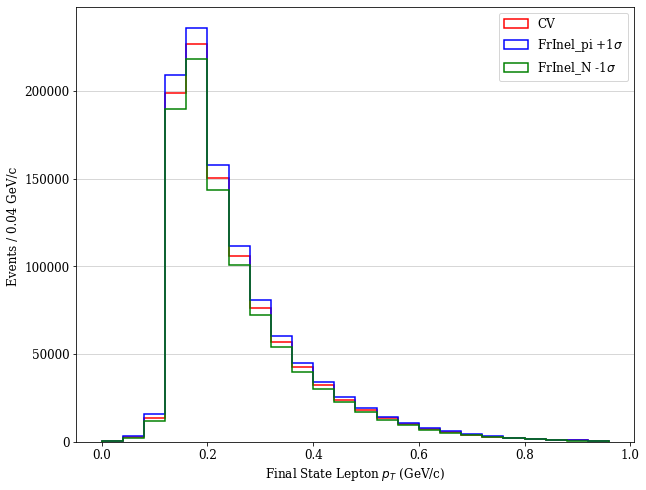

In [36]:
bins = np.arange(0,1.0,0.04)
var="ptl"
units="GeV/c"
q=''
#title="%s, $\\nu_\mu$ CC"%(fd_title)
xlabel="Final State Lepton $p_{T}$ (%s)"%(units)
ylabel="Events / %2.2f %s "%(bins[-1]-bins[-2],units)

df=gst_df#.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df[var], weights=df["wght"], color='red', label="CV", bins=bins,**pltops_hist)
plt.hist(df[var], weights=df["wght_FrInel_pi_p1"], color='blue', label="FrInel_pi +1$\sigma$", bins=bins,**pltops_hist)
plt.hist(df[var], weights=df["wght_FrInel_pi_n1"], color='green', bins=bins, label="FrInel_N -1$\sigma$", **pltops_hist)
plt.legend()
#plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
#plt.savefig("/Users/wketchum/Downloads/numucc_e_%s.png"%fd_leg)

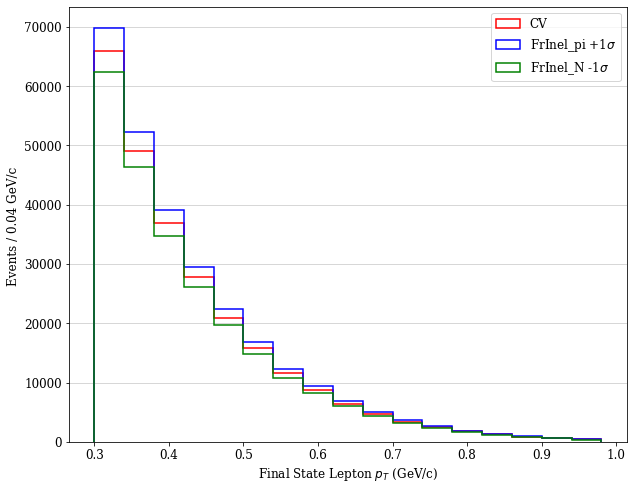

In [37]:
bins = np.arange(0.3,1.0,0.04)
var="ptl"
units="GeV/c"
q='ptl>0.4'
#title="%s, $\\nu_\mu$ CC"%(fd_title)
xlabel="Final State Lepton $p_{T}$ (%s)"%(units)
ylabel="Events / %2.2f %s "%(bins[-1]-bins[-2],units)

df=gst_df#.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df[var], weights=df["wght"], color='red', label="CV", bins=bins,**pltops_hist)
plt.hist(df[var], weights=df["wght_FrInel_pi_p1"], color='blue', label="FrInel_pi +1$\sigma$", bins=bins,**pltops_hist)
plt.hist(df[var], weights=df["wght_FrInel_pi_n1"], color='green', bins=bins, label="FrInel_N -1$\sigma$", **pltops_hist)
plt.legend()
#plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
#plt.savefig("/Users/wketchum/Downloads/numucc_e_%s.png"%fd_leg)

In [ ]:
bins = np.arange(0.4,1.0,0.04)
var="ptl"
units="GeV/c"
q='ptl>0.4'
#title="%s, $\\nu_\mu$ CC"%(fd_title)
xlabel="Final State Lepton $p_{T}$ (%s)"%(units)
ylabel="Events / %2.2f %s "%(bins[-1]-bins[-2],units)

df=gst_df_test.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df[var], weights=df["wght"], color='red', label="CV", bins=bins,**pltops_hist)
plt.hist(df[var], weights=df["wght_frabsN_p2"], color='blue', label="FrAbs_N +2$\sigma$", bins=bins,**pltops_hist)
plt.hist(df[var], weights=df["wght_frabsN_n2"], color='green', bins=bins, label="FrAbs_N -2$\sigma$", **pltops_hist)
plt.legend()
#plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
plt.savefig("/Users/wketchum/Downloads/ldmx_%s_%s.png"%(var,"frabsN"))

In [ ]:
bins = np.arange(0.5,4.5,1.)
var="n_n"
units=""
q='ptl>0.4'
#title="%s, $\\nu_\mu$ CC"%(fd_title)
xlabel="Final State Neutrons (>500 MeV KE)%s"%(units)
ylabel="Events / %2.2f %s "%(bins[-1]-bins[-2],units)

df=gst_df_test.query(q)

#df_cv = ev_df_cv.query(q)
#df_fd = ev_df_fd.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df[var], weights=df["wght"], color='red', label="CV", bins=bins,**pltops_hist)
plt.hist(df[var], weights=df["wght_frabsN_p2"], color='blue', label="FrAbs_N +2$\sigma$", bins=bins,**pltops_hist)
plt.hist(df[var], weights=df["wght_frabsN_n2"], color='green', bins=bins, label="FrAbs_N -2$\sigma$", **pltops_hist)
plt.legend()
#plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
#plt.yscale("log")
plt.show()

In [ ]:
bins = np.arange(0.0,1.,0.05)
var="ke_n1"
units="GeV"
q='ptl>0.4'
title="Leading Neutron Kinetic Energy\n(Trigger and Acceptance Applied)"
xlabel="Kinetic Energy (%s)"%(units)
ylabel="Events / %2.2f %s "%(bins[-1]-bins[-2],units)

df=gst_df_test.query(q)

#df_cv = ev_df_cv.query(q)
#df_fd = ev_df_fd.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df[var], weights=df["wght"], color='red', label="CV", bins=bins,**pltops_hist)
plt.hist(df[var], weights=df["wght_frabsN_p2"], color='blue', label="FrAbs_N +2$\sigma$", bins=bins,**pltops_hist)
plt.hist(df[var], weights=df["wght_frabsN_n2"], color='green', bins=bins, label="FrAbs_N -2$\sigma$", **pltops_hist)
plt.legend()
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.yscale("log")
plt.show()
plt.savefig("/Users/wketchum/Downloads/ldmx_%s_%s.png"%(var,"frabsN"))

In [ ]:
bins = np.arange(0.0,40.,5.)
#bins = np.arange(-1.0,1.0,0.1)
var="thetaz_n1"
units="degrees"
q='ptl>0.4 and ke_n1>0.5'
title="Leading Neutron $\\theta_z$\n(Trigger and Acceptance Applied)"
xlabel="$\\theta_z$ (%s)"%(units)
ylabel="Events / %2.2f %s "%(bins[-1]-bins[-2],units)

df=gst_df_test.query(q)

#df_cv = ev_df_cv.query(q)
#df_fd = ev_df_fd.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(np.degrees(df[var]), weights=df["wght"], color='red', label="CV", bins=bins,**pltops_hist)
plt.hist(np.degrees(df[var]), weights=df["wght_frabsN_p2"], color='blue', label="FrAbs_N +2$\sigma$", bins=bins,**pltops_hist)
plt.hist(np.degrees(df[var]), weights=df["wght_frabsN_n2"], color='green', bins=bins, label="FrAbs_N -2$\sigma$", **pltops_hist)
plt.legend(loc=2)
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
#plt.yscale("log")
plt.show()

In [ ]:
bins = np.arange(0.4,1.0,0.04)
var="ptl"
units="GeV/c"
q='ptl>0.4 and ke_n1>0.5'
#title="%s, $\\nu_\mu$ CC"%(fd_title)
xlabel="Final State Lepton $p_{T}$ (%s)"%(units)
ylabel="Events / %2.2f %s "%(bins[-1]-bins[-2],units)

df=gst_df_test.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df[var], weights=df["wght"], color='red', label="CV", bins=bins,**pltops_hist)
plt.hist(df[var], weights=df["wght_frabsN_p2"], color='blue', label="FrAbs_N +2$\sigma$", bins=bins,**pltops_hist)
plt.hist(df[var], weights=df["wght_frabsN_n2"], color='green', bins=bins, label="FrAbs_N -2$\sigma$", **pltops_hist)
plt.legend()
#plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
plt.savefig("/Users/wketchum/Downloads/ldmx_%s_%s.png"%(var,"frabsN"))

In [ ]:
bins = np.arange(0.0,1.,0.05)
var="ke_n1"
units="GeV"
q='ptl>0.4'
title="Leading Neutron Kinetic Energy\n(Trigger and Acceptance Applied)"
xlabel="Kinetic Energy (%s)"%(units)
ylabel="Events / %2.2f %s "%(bins[-1]-bins[-2],units)

df=gst_df_test.query(q)

#df_cv = ev_df_cv.query(q)
#df_fd = ev_df_fd.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df[var], weights=df["wght"], color='red', label="CV", bins=bins,**pltops_hist)
plt.hist(df[var], weights=df["wght_frinelN_p2"], color='blue', label="FrInel_N +2$\sigma$", bins=bins,**pltops_hist)
plt.hist(df[var], weights=df["wght_frinelN_n2"], color='green', bins=bins, label="FrInel_N -2$\sigma$", **pltops_hist)
plt.legend()
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.yscale("log")
plt.show()
plt.savefig("/Users/wketchum/Downloads/ldmx_%s_%s.png"%(var,"frinelN"))

In [ ]:
bins = np.arange(0.5,4.5,1.)
var="n_p"
units=""
q='ptl>0.4'
#title="%s, $\\nu_\mu$ CC"%(fd_title)
xlabel="Final State Protons (>100 MeV KE)%s"%(units)
ylabel="Events / %2.2f %s "%(bins[-1]-bins[-2],units)

df=gst_df_test.query(q)

#df_cv = ev_df_cv.query(q)
#df_fd = ev_df_fd.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df[var], weights=df["wght"], color='red', label="CV", bins=bins,**pltops_hist)
plt.hist(df[var], weights=df["wght_frabsN_p2"], color='blue', label="FrAbs_N +2$\sigma$", bins=bins,**pltops_hist)
plt.hist(df[var], weights=df["wght_frabsN_n2"], color='green', bins=bins, label="FrAbs_N -2$\sigma$", **pltops_hist)
plt.legend()
#plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
#plt.yscale("log")
plt.show()

In [ ]:
bins = np.arange(0.0,1.,0.05)
var="ke_p1"
units="GeV"
q='ptl>0.4'
title="Leading Proton Kinetic Energy\n(Trigger and Acceptance Applied)"
xlabel="Kinetic Energy (%s)"%(units)
ylabel="Events / %2.2f %s "%(bins[-1]-bins[-2],units)

df=gst_df_test.query(q)

#df_cv = ev_df_cv.query(q)
#df_fd = ev_df_fd.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df[var], weights=df["wght"], color='red', label="CV", bins=bins,**pltops_hist)
plt.hist(df[var], weights=df["wght_frabsN_p2"], color='blue', label="FrAbs_N +2$\sigma$", bins=bins,**pltops_hist)
plt.hist(df[var], weights=df["wght_frabsN_n2"], color='green', bins=bins, label="FrAbs_N -2$\sigma$", **pltops_hist)
plt.legend()
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
#plt.yscale("log")
plt.show()
plt.savefig("/Users/wketchum/Downloads/ldmx_%s_%s.png"%(var,"frabsN"))

In [ ]:
bins = np.arange(0.5,4.5,1.)
var="n_p"
units=""
q='ptl>0.4'
#title="%s, $\\nu_\mu$ CC"%(fd_title)
xlabel="Final State Protons (>100 MeV KE)%s"%(units)
ylabel="Events / %2.2f %s "%(bins[-1]-bins[-2],units)

df=gst_df_test.query(q)

#df_cv = ev_df_cv.query(q)
#df_fd = ev_df_fd.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df[var], weights=df["wght"], color='red', label="CV", bins=bins,**pltops_hist)
plt.hist(df[var], weights=df["wght_frinelN_p2"], color='blue', label="FrInel_N +2$\sigma$", bins=bins,**pltops_hist)
plt.hist(df[var], weights=df["wght_frinelN_n2"], color='green', bins=bins, label="FrInel_N -2$\sigma$", **pltops_hist)
plt.legend()
#plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
#plt.yscale("log")
plt.show()

In [ ]:
bins = np.arange(0.0,1.,0.025)
var="ke_p1"
units="GeV"
q='ptl>0.4'
title="Leading Proton Kinetic Energy\n(Trigger and Acceptance Applied)"
xlabel="Kinetic Energy (%s)"%(units)
ylabel="Events / %2.2f %s "%(bins[-1]-bins[-2],units)

df=gst_df_test.query(q)

#df_cv = ev_df_cv.query(q)
#df_fd = ev_df_fd.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df[var], weights=df["wght"], color='red', label="CV", bins=bins,**pltops_hist)
plt.hist(df[var], weights=df["wght_frinelN_p2"], color='blue', label="FrInel_N +2$\sigma$", bins=bins,**pltops_hist)
plt.hist(df[var], weights=df["wght_frinelN_n2"], color='green', bins=bins, label="FrInel_N -2$\sigma$", **pltops_hist)
plt.legend()
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
#plt.yscale("log")
plt.show()
plt.savefig("/Users/wketchum/Downloads/ldmx_%s_%s.png"%(var,"frinelN"))

In [ ]:
gst_df_test[["qel","res","dis","mec"]]

In [ ]:
bins = np.arange(0.3,1.5,0.05)
var="ptl"
units="GeV/c"
q_qel='ptl>0.4 and qel'
q_mec='ptl>0.4 and mec'
q_res='ptl>0.4 and res'
q_dis='ptl>0.4 and dis'
q_oth='ptl>0.4 and not (dis or mec or res or qel)'
#title="%s, $\\nu_\mu$ CC"%(fd_title)
xlabel="Final State Lepton $p_{T}$ (%s)"%(units)
ylabel="Events / %2.2f %s "%(bins[-1]-bins[-2],units)

df_qel=gst_df_test.query(q_qel)
df_mec=gst_df_test.query(q_mec)
df_res=gst_df_test.query(q_res)
df_dis=gst_df_test.query(q_dis)
df_oth=gst_df_test.query(q_oth)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_qel[var], weights=df_qel["wght"], label="QE", bins=bins,**pltops_hist)
plt.hist(df_mec[var], weights=df_mec["wght"], label="MEC", bins=bins,**pltops_hist)
plt.hist(df_res[var], weights=df_res["wght"], label="RES", bins=bins,**pltops_hist)
plt.hist(df_dis[var], weights=df_dis["wght"], label="DIS", bins=bins,**pltops_hist)
plt.hist(df_oth[var], weights=df_oth["wght"], label="Other", bins=bins,**pltops_hist)
plt.legend()
#plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
plt.savefig("/Users/wketchum/Downloads/ldmx_%s_%s.png"%(var,"inttype"))

In [ ]:
bins = np.arange(0.3,1.5,0.05)
var="ptl"
units="GeV/c"
q_qel='ptl>0.2 and qel'
q_mec='ptl>0.2 and mec'
q_res='ptl>0.2 and res'
q_dis='ptl>0.2 and dis'
#title="%s, $\\nu_\mu$ CC"%(fd_title)
xlabel="Final State Lepton $p_{T}$ (%s)"%(units)
ylabel="Events / %2.2f %s "%(bins[-1]-bins[-2],units)

df_qel=gst_df_test.query(q_qel)
df_mec=gst_df_test.query(q_mec)
df_res=gst_df_test.query(q_res)
df_dis=gst_df_test.query(q_dis)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_qel[var], weights=df_qel["wght"], label="QE", bins=bins,**pltops_hist)
plt.hist(df_mec[var], weights=df_mec["wght"], label="MEC", bins=bins,**pltops_hist)
plt.hist(df_res[var], weights=df_res["wght"], label="RES", bins=bins,**pltops_hist)
plt.hist(df_dis[var], weights=df_dis["wght"], label="DIS", bins=bins,**pltops_hist)
plt.legend()
#plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
plt.savefig("/Users/wketchum/Downloads/ldmx_%s_%s.png"%(var,"inttype"))

In [ ]:
bins = np.arange(0,75,5)
var="thetal"
units="degrees"
q_qel='ptl>0.4 and qel'
q_res='ptl>0.4 and res'
q_dis='ptl>0.4 and dis'
#q_qel='ptl>0.1 and qel'
#q_res='ptl>0.1 and res'
#q_dis='ptl>0.1 and dis'
#title="%s, $\\nu_\mu$ CC"%(fd_title)
xlabel="Final State Lepton $\\theta$ (%s)"%(units)
ylabel="Events / %2.2f %s "%(bins[-1]-bins[-2],units)

df_qel=gst_df_test.query(q_qel)
df_res=gst_df_test.query(q_res)
df_dis=gst_df_test.query(q_dis)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(np.degrees(df_qel[var]), weights=df_qel["wght"], label="QE", bins=bins,**pltops_hist)
plt.hist(np.degrees(df_res[var]), weights=df_res["wght"], label="RES", bins=bins,**pltops_hist)
plt.hist(np.degrees(df_dis[var]), weights=df_dis["wght"], label="DIS", bins=bins,**pltops_hist)
plt.legend()
#plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
#plt.savefig("/Users/wketchum/Downloads/ldmx_%s_%s.png"%(var,"frabsN"))

In [ ]:
bins = np.arange(0.4,1.0,0.04)
var="ptl"
units="GeV/c"
q='ptl>0.4'
#title="%s, $\\nu_\mu$ CC"%(fd_title)
xlabel="Final State Lepton $p_{T}$ (%s)"%(units)
ylabel="Events / %2.2f %s "%(bins[-1]-bins[-2],units)

df=gst_df_test.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df[var], weights=df["wght"], color='red', label="CV", bins=bins,**pltops_hist)
plt.hist(df[var], weights=df["wght_MvNCRES_p2"], color='blue', label="MvNCRES +2$\sigma$", bins=bins,**pltops_hist)
plt.hist(df[var], weights=df["wght_MvNCRES_n2"], color='green', bins=bins, label="MvNCRES -2$\sigma$", **pltops_hist)
plt.legend()
#plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
plt.savefig("/Users/wketchum/Downloads/ldmx_%s_%s.png"%(var,"MvNCRES"))

In [ ]:
bins = np.arange(0,4.1,0.1)
var="pzv"
units="GeV"
q=''
#title="%s, $\\nu_\mu$ CC"%(fd_title)
xlabel="Initial State Energy $E$ (%s)"%(units)
ylabel="Events / %2.2f %s "%(bins[-1]-bins[-2],units)

#df_cv = ev_df_cv.query(q)
#df_fd = ev_df_fd.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(gst_df[var], weights=gst_df["wght"], color='red', bins=bins,**pltops_hist)
#plt.legend()
#plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
#plt.savefig("/Users/wketchum/Downloads/numucc_e_%s.png"%fd_leg)

In [ ]:
w_ahtbyshape_df = uproot.open(weights_file)['FrAbs_N'].pandas.df(flatten=False)

In [ ]:
w_ahtbyshape_df

In [ ]:
gst_df_test = gst_df.loc[:9999]

In [ ]:
gst_df_test = gst_df_test.merge(w_ahtbyshape_df,how="left",on=["entry"])

In [ ]:
gst_df_test["wght_frabsN_n1"] = gst_df_test["weights"].apply(lambda x: x[0])
gst_df_test["wght_frabsN_p1"] = gst_df_test["weights"].apply(lambda x: x[2])

In [ ]:
bins = np.arange(-0.5,9.5,1.)
var="nfp"
units=""
q=''
#title="%s, $\\nu_\mu$ CC"%(fd_title)
xlabel="Final State Protons (%s)"%(units)
ylabel="Events / %2.2f %s "%(bins[-1]-bins[-2],units)

#df_cv = ev_df_cv.query(q)
#df_fd = ev_df_fd.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(gst_df_test[var], weights=gst_df_test["wght"], color='red', label="CV", bins=bins,**pltops_hist)
plt.hist(gst_df_test[var], weights=gst_df_test["wght_frabsN_p1"], color='blue', label="FrAbs_N +1$\sigma$", bins=bins,**pltops_hist)
plt.hist(gst_df_test[var], weights=gst_df_test["wght_frabsN_n1"], color='green', bins=bins, label="FrAbs_N -1$\sigma$", **pltops_hist)
plt.legend()
#plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
plt.savefig("/Users/wketchum/Downloads/ldmx_%s_%s.png"%("frabsN",var))

In [ ]:
bins = np.arange(-0.5,9.5,1.)
var="nfn"
units=""
q=''
#title="%s, $\\nu_\mu$ CC"%(fd_title)
xlabel="Final State Neutrons %s"%(units)
ylabel="Events / %2.2f %s "%(bins[-1]-bins[-2],units)

#df_cv = ev_df_cv.query(q)
#df_fd = ev_df_fd.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(gst_df_test[var], weights=gst_df_test["wght"], color='red', label="CV", bins=bins,**pltops_hist)
plt.hist(gst_df_test[var], weights=gst_df_test["wght_frabsN_p1"], color='blue', label="FrAbs_N +1$\sigma$", bins=bins,**pltops_hist)
plt.hist(gst_df_test[var], weights=gst_df_test["wght_frabsN_n1"], color='green', bins=bins, label="FrAbs_N -1$\sigma$", **pltops_hist)
plt.legend()
#plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
plt.savefig("/Users/wketchum/Downloads/ldmx_%s_%s.png"%("frabsN",var))

In [ ]:
bins = np.arange(0.5,1.5,0.01)
#var="nfn"
units=""
q=''
#title="%s, $\\nu_\mu$ CC"%(fd_title)
xlabel="Weights %s"%(units)
ylabel="Events / %2.2f %s "%(bins[-1]-bins[-2],units)

#df_cv = ev_df_cv.query(q)
#df_fd = ev_df_fd.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(gst_df_test["wght_frabsN_p1"], color='blue', label="FrAbs_N +1$\sigma$", bins=bins,**pltops_hist)
plt.hist(gst_df_test["wght_frabsN_n1"], color='green', bins=bins, label="FrAbs_N -1$\sigma$", **pltops_hist)
plt.legend()
#plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
plt.savefig("/Users/wketchum/Downloads/ldmx_%s_%s.png"%("frabsN","weights"))

In [ ]:
weights_file = "/Users/wketchum/Data/LDMX/weights_AhtBYshpe_test.root"

w_ahtbyshape_df = uproot.open(weights_file)['AhtBYshape'].pandas.df(flatten=False)
gst_df_test = gst_df_test.merge(w_ahtbyshape_df,how="left",on=["entry"],suffixes=["","_ahtbyshp"])

In [ ]:
weights_file = "/Users/wketchum/Data/LDMX/weights_BhtBYshape_test.root"

w_ahtbyshape_df = uproot.open(weights_file)['BhtBYshape'].pandas.df(flatten=False)
gst_df_test = gst_df_test.merge(w_bhtbyshape_df,how="left",on=["entry"],suffixes=["","_bhtbyshp"])

In [ ]:
gst_df_test

In [ ]:
gst_df_test["wght_ahtbyshp_n1"] = gst_df_test["weights_ahtbyshp"].apply(lambda x: x[0])
gst_df_test["wght_ahtbyshp_p1"] = gst_df_test["weights_ahtbyshp"].apply(lambda x: x[2])

gst_df_test["wght_bhtbyshp_n1"] = gst_df_test["weights_bhtbyshp"].apply(lambda x: x[0])
gst_df_test["wght_bhtbyshp_p1"] = gst_df_test["weights_bhtbyshp"].apply(lambda x: x[2])

In [ ]:
np.max(gst_df_test["wght_bhtbyshp_p1"])

In [ ]:
weights_file = "/Users/wketchum/Data/LDMX/weights_MvNCRES_test.root"

w_ahtbyshape_df = uproot.open(weights_file)['MvNCRES'].pandas.df(flatten=False)
gst_df_test = gst_df_test.merge(w_ahtbyshape_df,how="left",on=["entry"],suffixes=["","_mvncres"])

In [ ]:
gst_df_test["wght_mvncres_n1"] = gst_df_test["weights_mvncres"].apply(lambda x: x[0])
gst_df_test["wght_mvncres_p1"] = gst_df_test["weights_mvncres"].apply(lambda x: x[2])

In [ ]:
np.max(gst_df_test["wght_mvncres_p1"])